### LSTM implementation

Enabling GPU

In [1]:
# checking if GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# different devices used during the execution of the notebook
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17980658262461566934
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6519975509401400838
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
# checking RAM
!cat /proc/meminfo

MemTotal:       13290480 kB
MemFree:         7713928 kB
MemAvailable:   11928740 kB
Buffers:          349224 kB
Cached:          4061280 kB
SwapCached:            0 kB
Active:          1072244 kB
Inactive:        4102468 kB
Active(anon):       1344 kB
Inactive(anon):   775104 kB
Active(file):    1070900 kB
Inactive(file):  3327364 kB
Unevictable:          16 kB
Mlocked:              16 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1632 kB
Writeback:             0 kB
AnonPages:        761388 kB
Mapped:           772420 kB
Shmem:             12100 kB
KReclaimable:     114976 kB
Slab:             162936 kB
SReclaimable:     114976 kB
SUnreclaim:        47960 kB
KernelStack:        5892 kB
PageTables:        10500 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6645240 kB
Committed_AS:    3212060 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       80244 kB
VmallocChunk:    

In [4]:
!nvidia-smi

Sun Jan 28 12:04:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              29W /  70W |    103MiB / 15360MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Recurrent Neural Network

#### Part 1 - Data Preprocessing

Importing the libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

Importing the training set

In [6]:
# Get the current working directory
current_directory = Path.cwd()

# Define the path to the CSV file
csv_file_path = current_directory / "datasets" / "Google Stock Price"

In [7]:
dataset_train = pd.read_csv(os.path.join(csv_file_path, 'Google_Stock_Price_Train.csv'))
training_set = dataset_train.iloc[:, 1:2].values

Feature Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)
training_set_scaled

(1258, 1)


array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

Creating a data structure with 60 timesteps and 1 output

In [9]:
X_train = []
y_train = []

for i in range(60, 1258):
  X_train.append(training_set_scaled[i-60:i, 0])
  y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
print(X_train.shape)
X_train

(1198, 60)


array([[0.08581368, 0.09701243, 0.09433366, ..., 0.07846566, 0.08034452,
        0.08497656],
       [0.09701243, 0.09433366, 0.09156187, ..., 0.08034452, 0.08497656,
        0.08627874],
       [0.09433366, 0.09156187, 0.07984225, ..., 0.08497656, 0.08627874,
        0.08471612],
       ...,
       [0.92106928, 0.92438053, 0.93048218, ..., 0.95475854, 0.95204256,
        0.95163331],
       [0.92438053, 0.93048218, 0.9299055 , ..., 0.95204256, 0.95163331,
        0.95725128],
       [0.93048218, 0.9299055 , 0.93113327, ..., 0.95163331, 0.95725128,
        0.93796041]])

In [11]:
print(y_train.shape)
y_train

(1198,)


array([0.08627874, 0.08471612, 0.07454052, ..., 0.95725128, 0.93796041,
       0.93688146])

Reshaping the Data

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

#### Part 2 - Building the RNN

Importing the Keras libraries and packages

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Initialising the RNN

In [14]:
regressor = Sequential()

Adding the first LSTM layer and some Dropout regularization

In [15]:
# LSTM Layer 1
regressor.add(LSTM(units=50,
                   return_sequences=True,
                   input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# LSTM Layer 2
regressor.add(LSTM(units=50, return_sequences=True,))
regressor.add(Dropout(0.2))

# LSTM Layer 3
regressor.add(LSTM(units=50, return_sequences=True,))
regressor.add(Dropout(0.2))

# LSTM Layer 4
regressor.add(LSTM(units=50,))
regressor.add(Dropout(0.2))

Adding the output layer

In [16]:
regressor.add(Dense(units = 1))

Compiling the RNN

In [17]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

#### Part 3 - Making the predictions and visualising the results

Fitting the RNN to the Training set

In [18]:
regressor.fit(X_train, y_train,
              epochs=100,
              batch_size=32,
              )

Epoch 1/100
38/38 [==============================] - 18s 17ms/step - loss: 0.0328
Epoch 2/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0069
Epoch 3/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0054
Epoch 4/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0067
Epoch 5/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0052
Epoch 6/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 7/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0047
Epoch 8/100
38/38 [==============================] - 1s 13ms/step - loss: 0.0052
Epoch 9/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0047
Epoch 10/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 11/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0042
Epoch 12/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 13/100
38/38 [====

Getting the real stock price of 2017

In [20]:
dataset_test = pd.read_csv(os.path.join(csv_file_path, 'Google_Stock_Price_Test.csv'))
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

Getting the predicted stock price of 2017

In [21]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [22]:
X_test = []

for i in range(60, 80):
  X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(20, 60, 1)

In [23]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 1s/step


Visualising the results

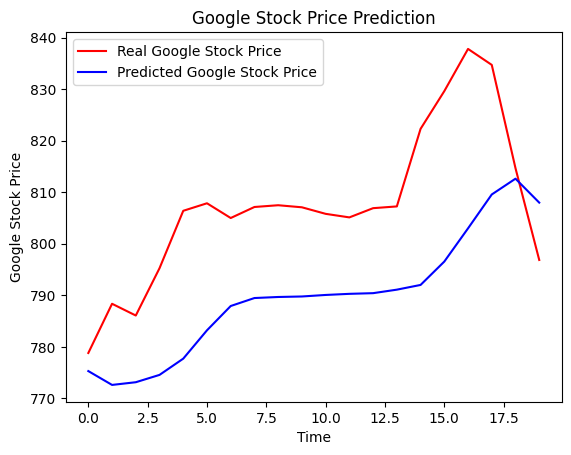

In [24]:
plt.plot(real_stock_price, color='red',
         label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue',
         label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()